# 1. Понимание бизнеса

## 1.1 Цель
Токсичные комментарии

## 1.2 Описание
- анализ датасета, состоящего из токсичных и нетоксичных комментариев из интернета;
- построение модели машинного обучения для классификации комментариев как токсичных и нетоксичных.

# 2. Понимание данных

## 2.1 Импорт библиотек

In [1]:
# встроенные библиотеки
from collections import Counter
import pickle
import re
import os
import warnings
warnings.filterwarnings("ignore")

# работа с датасетом
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix, hstack
tqdm.pandas()

# построение графиков, визуализация
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 10)

# обработка текста
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud, STOPWORDS

# построение модели
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

## 2.2 Загрузка данных

In [2]:
comments = pd.read_csv('comments.csv')
comments.info()
comments.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


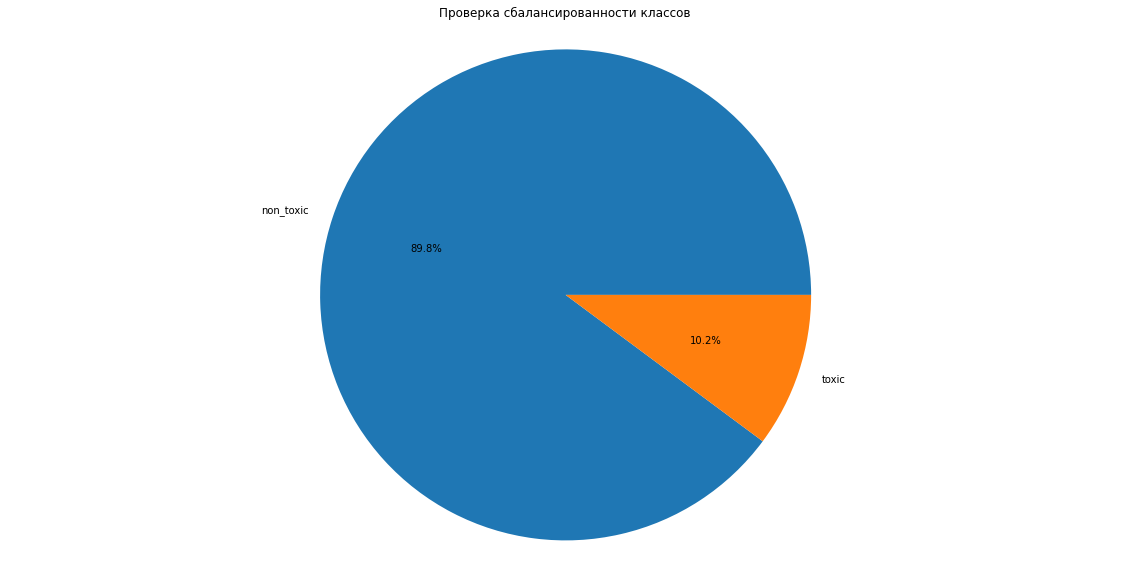

In [3]:
fig1, ax1 = plt.subplots()
ax1.pie(comments['toxic'].value_counts().to_list(), labels=['non_toxic', 'toxic'], autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Проверка сбалансированности классов')

plt.show()

In [4]:
stopwords_set = set(stopwords.words('english'))
stopwords_set.update(STOPWORDS)
sorted(stopwords_set)[:10]

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'also',
 'am']

In [5]:
# Добавляем столбцы с токенами
toketizer = TweetTokenizer()

def get_tokens(text):
    text = re.sub(r'\d+', ' ', text.lower())
    words = toketizer.tokenize(text)
    new_words = [word for word in words if word.isalnum() and word not in stopwords_set]
    return new_words

comments['tokens'] = comments['text'].progress_apply(get_tokens)
comments['tokens_count'] = comments['tokens'].str.len()
comments['char_count'] = comments['text'].str.len()
comments.head()

100%|████████████████████████████████████████████████████████████████████████| 159571/159571 [00:48<00:00, 3319.12it/s]


,text,toxic,tokens,tokens_count,char_count
0,Explanation\nWhy the edits made under my usern...,0,"[explanation, edits, made, username, hardcore,...",22,264
1,D'aww! He matches this background colour I'm s...,0,"[matches, background, colour, seemingly, stuck...",9,112
2,"Hey man, I'm really not trying to edit war. It...",0,"[hey, man, really, trying, edit, war, guy, con...",21,233
3,"""\nMore\nI can't make any real suggestions on ...",0,"[make, real, suggestions, improvement, wondere...",46,622
4,"You, sir, are my hero. Any chance you remember...",0,"[sir, hero, chance, remember, page]",5,67


In [6]:
toxic = comments[comments['toxic'] == 1]
toxic5_texts = toxic['text'].head(2).to_list()
print('\n\n'.join(toxic5_texts))

COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK

Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings...


In [7]:
non_toxic = comments[comments['toxic'] == 0][:len(toxic)]
non_toxic5_texts = non_toxic['text'].head(2).to_list()
print('\n\n'.join(non_toxic5_texts))

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)


In [8]:
comments = pd.concat([toxic, non_toxic]).sort_index()
comments.head()

,text,toxic,tokens,tokens_count,char_count
0,Explanation\nWhy the edits made under my usern...,0,"[explanation, edits, made, username, hardcore,...",22,264
1,D'aww! He matches this background colour I'm s...,0,"[matches, background, colour, seemingly, stuck...",9,112
2,"Hey man, I'm really not trying to edit war. It...",0,"[hey, man, really, trying, edit, war, guy, con...",21,233
3,"""\nMore\nI can't make any real suggestions on ...",0,"[make, real, suggestions, improvement, wondere...",46,622
4,"You, sir, are my hero. Any chance you remember...",0,"[sir, hero, chance, remember, page]",5,67


## 2.3 Статистика и визуализации
### 2.3.1 Облако слов

(-0.5, 399.5, 199.5, -0.5)

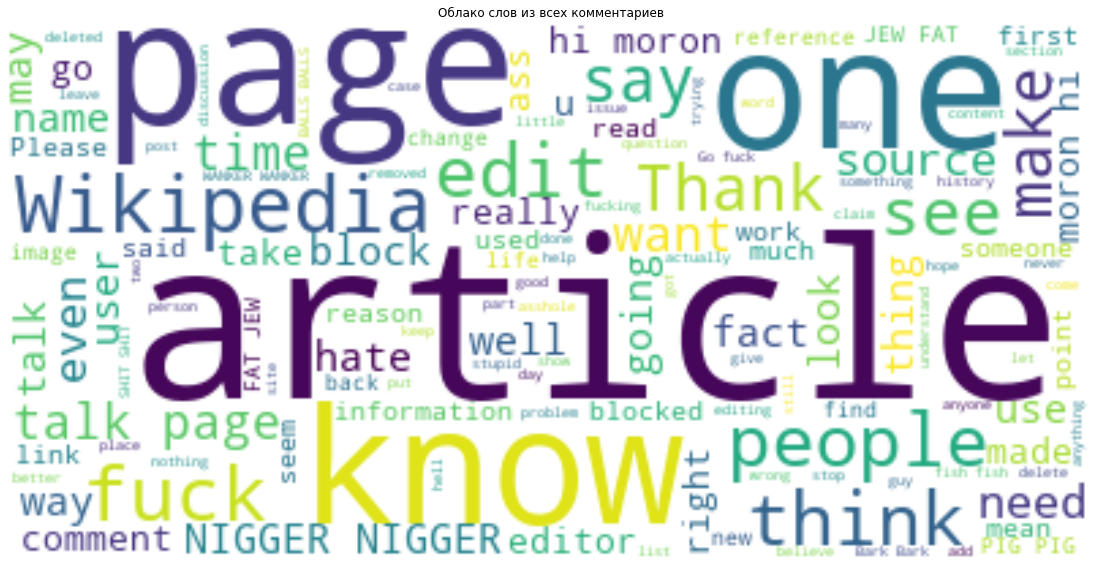

In [9]:
wordcloud = WordCloud(background_color="white", stopwords=stopwords_set).generate(' '.join(comments['text']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Облако слов из всех комментариев")
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

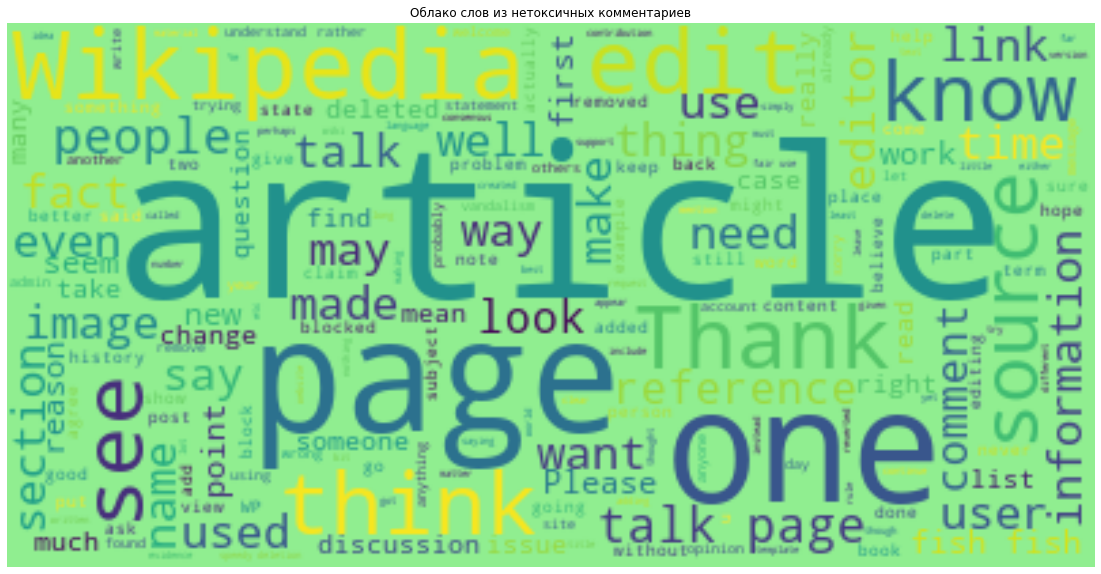

In [10]:
non_toxic_text = ' '.join(non_toxic['text'])

wordcloud = (
    WordCloud(background_color="lightgreen", stopwords=stopwords_set)
    .generate(non_toxic_text)
)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Облако слов из нетоксичных комментариев")
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

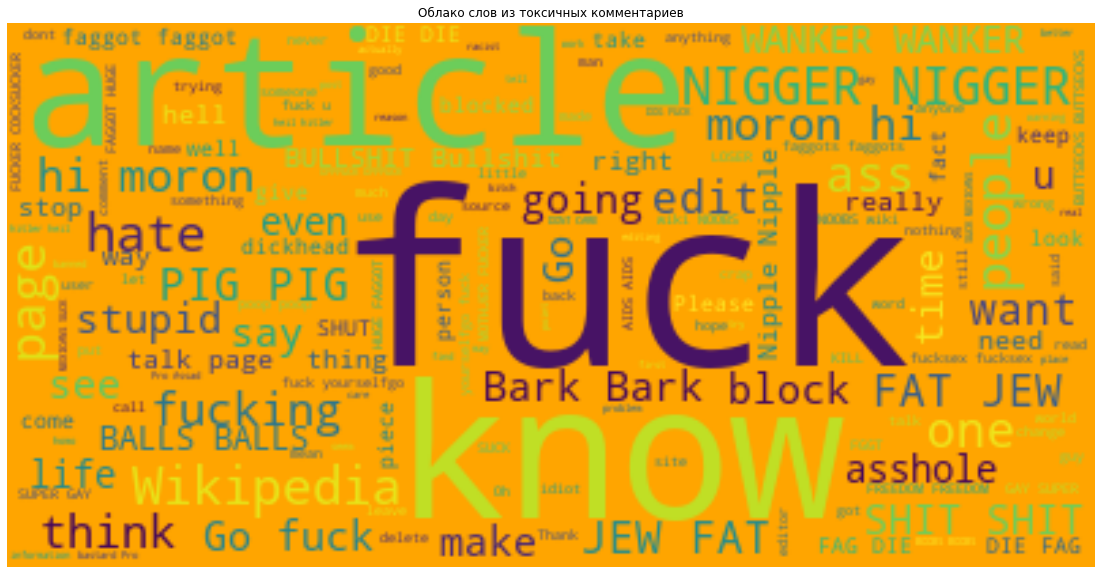

In [11]:
toxic_text = ' '.join(toxic['text'])

wordcloud = (
    WordCloud(background_color="orange", stopwords=stopwords_set)
    .generate(toxic_text)
)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Облако слов из токсичных комментариев")
plt.axis("off")

### 2.3.2 Сравнение количества слов

In [12]:
toxic_tokens_cnt = Counter()  # счетчик длин твитов по словам (ключ: длина твита, значение: кол-во твитов такой длины)
toxic_tokens_cnt.update(toxic['tokens_count'])

print('Счетчик слов в нетоксичных комментариях')
print('Формат: (<кол-во слов в комментарии>, <кол-во комментариев с таким кол-вом слов>)')
toxic_tokens_cnt.most_common(5)

Счетчик слов в нетоксичных комментариях
Формат: (<кол-во слов в комментарии>, <кол-во комментариев с таким кол-вом слов>)


[(4, 1090), (5, 1058), (3, 1019), (6, 949), (7, 810)]

In [13]:
non_toxic_tokens_cnt = Counter()  # счетчик длин твитов по словам (ключ: длина твита, значение: кол-во твитов такой длины)
non_toxic_tokens_cnt.update(non_toxic['tokens_count'])

print('Счетчик слов в токсичных комментариях')
print('Формат: (<кол-во слов в комментарии>, <кол-во комментариев с таким кол-вом слов>)')
non_toxic_tokens_cnt.most_common(5)

Счетчик слов в токсичных комментариях
Формат: (<кол-во слов в комментарии>, <кол-во комментариев с таким кол-вом слов>)


[(6, 650), (5, 628), (4, 614), (3, 593), (8, 548)]

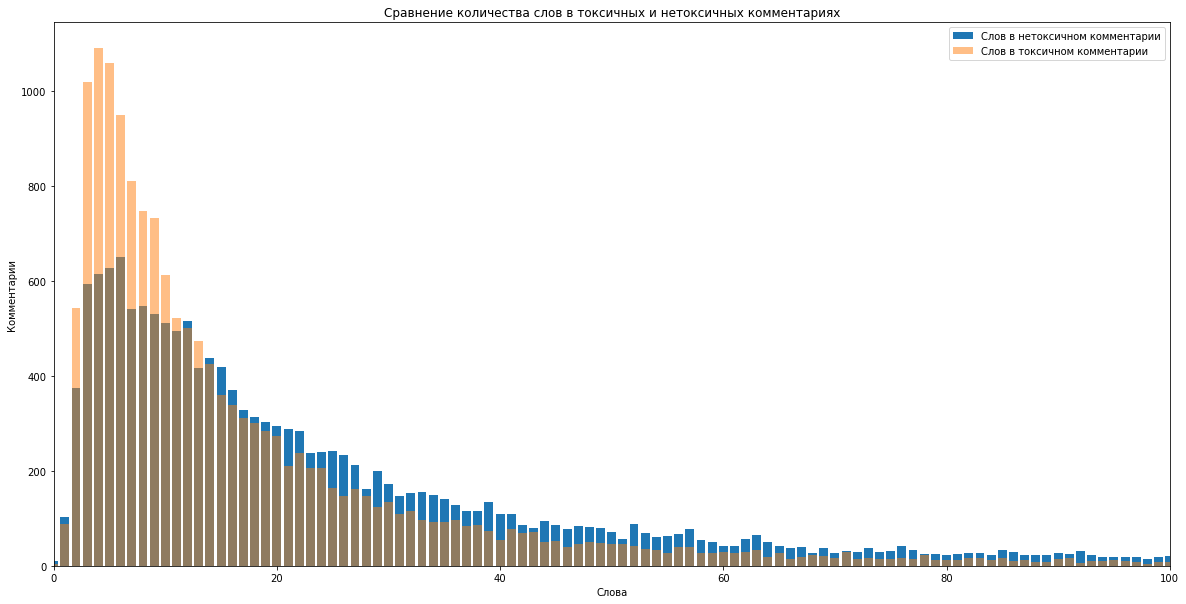

In [14]:
# line 1 points
x1 = non_toxic_tokens_cnt.keys()
y1 = non_toxic_tokens_cnt.values()
# plotting the line 1 points 
plt.bar(x1, y1, label = "Слов в нетоксичном комментарии")
# line 2 points
x2 = toxic_tokens_cnt.keys()
y2 = toxic_tokens_cnt.values()
# plotting the line 2 points 
plt.bar(x2, y2, label = "Слов в токсичном комментарии", alpha=0.5)
plt.xlabel('Слова')
# Set the y axis label of the current axis.
plt.ylabel('Комментарии')
# Set a title of the current axes.
plt.title('Сравнение количества слов в токсичных и нетоксичных комментариях')
# show a legend on the plot
plt.legend()
plt.xlim((0, 100))
# Display a figure.
plt.show()

### 2.3.3 Сравнение количества символов

In [15]:
toxic_char_cnt = Counter()  # счетчик длин твитов по символам (ключ: длина твита, значение: кол-во твитов такой длины)
toxic_char_cnt.update(toxic['char_count'])

print('Счетчик символов в токсичных комментариях')
print('Формат: (<кол-во символов в комментарии>, <кол-во комментариев с таким кол-вом символов>)')
toxic_char_cnt.most_common(5)

Счетчик символов в токсичных комментариях
Формат: (<кол-во символов в комментарии>, <кол-во комментариев с таким кол-вом символов>)


[(23, 123), (34, 123), (31, 115), (27, 113), (32, 112)]

In [16]:
non_toxic_char_cnt = Counter()  # счетчик длин твитов по символам (ключ: длина твита, значение: кол-во твитов такой длины)
non_toxic_char_cnt.update(non_toxic['char_count'])

print('Счетчик символов в нетоксичных комментариях')
print('Формат: (<кол-во символов в комментарии>, <кол-во комментариев с таким кол-вом символов>)')
non_toxic_char_cnt.most_common(5)

Счетчик символов в нетоксичных комментариях
Формат: (<кол-во символов в комментарии>, <кол-во комментариев с таким кол-вом символов>)


[(45, 70), (33, 68), (24, 66), (58, 63), (89, 63)]

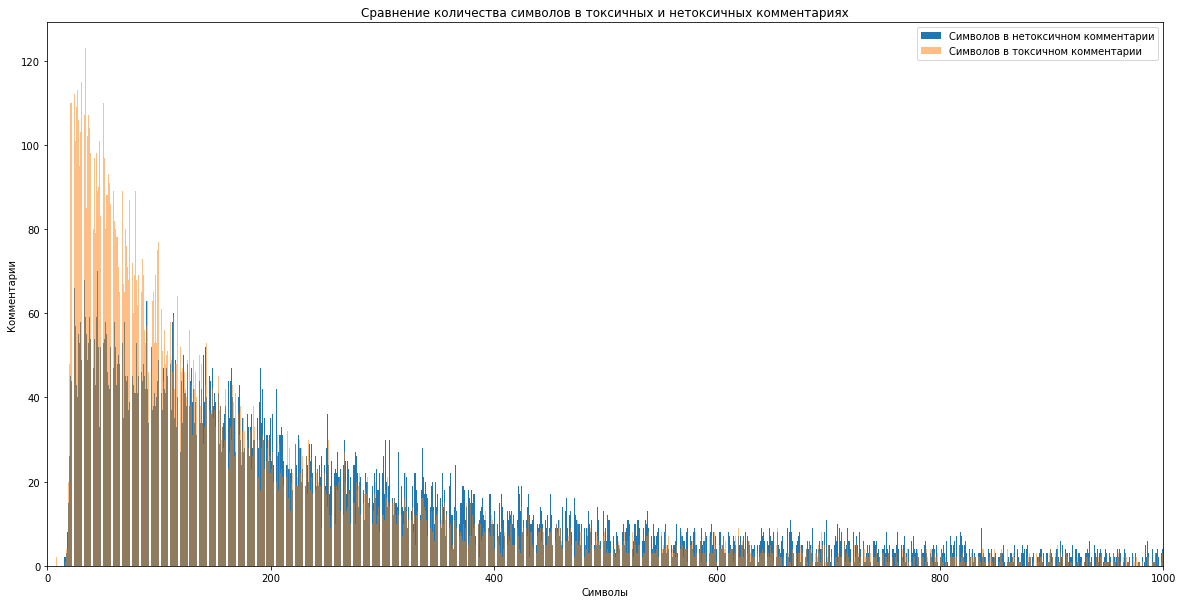

In [17]:
# line 1 points
x1 = non_toxic_char_cnt.keys()
y1 = non_toxic_char_cnt.values()
# plotting the line 1 points 
plt.bar(x1, y1, label = "Символов в нетоксичном комментарии")
# line 2 points
x2 = toxic_char_cnt.keys()
y2 = toxic_char_cnt.values()
# plotting the line 2 points 
plt.bar(x2, y2, label = "Символов в токсичном комментарии", alpha=0.5)
plt.xlabel('Символы')
# Set the y axis label of the current axis.
plt.ylabel('Комментарии')
# Set a title of the current axes.
plt.title('Сравнение количества символов в токсичных и нетоксичных комментариях')
# show a legend on the plot
plt.legend()
plt.xlim((0, 1000))
# Display a figure.
plt.show()

### 2.3.4 Кривая Ципфа

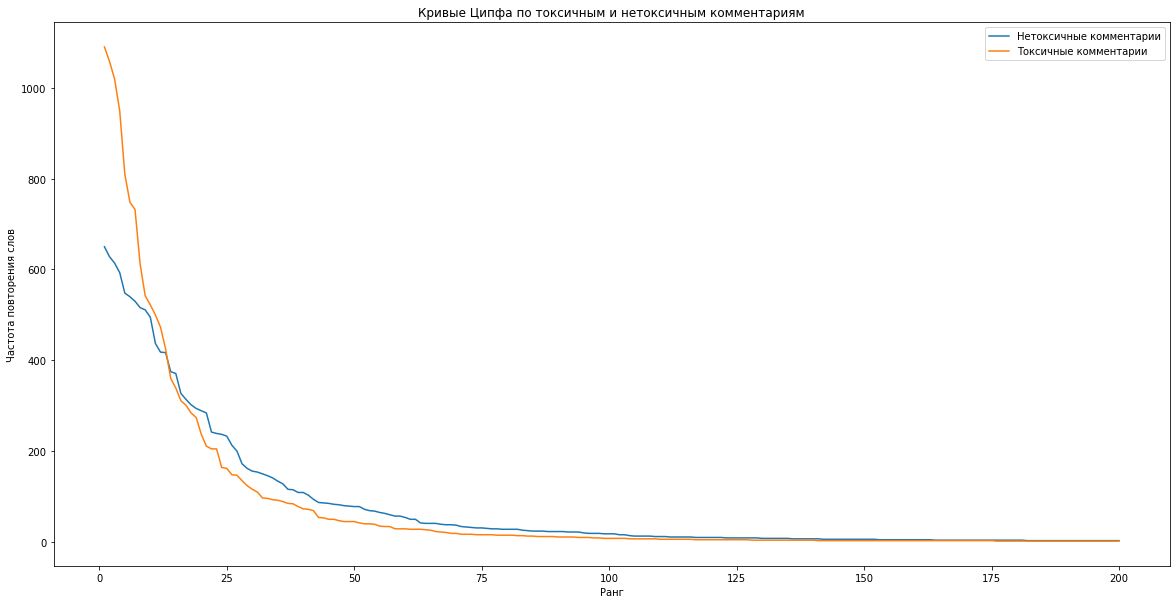

In [18]:
size = 200
x = range(1, size + 1)

non_toxic_freqs = sorted(non_toxic_tokens_cnt.values(), reverse = True)
plt.plot(x, non_toxic_freqs[:size], label = "Нетоксичные комментарии")

toxic_freqs = sorted(toxic_tokens_cnt.values(), reverse = True)
plt.plot(x, toxic_freqs[:size], label = "Токсичные комментарии")

plt.title('Кривые Ципфа по токсичным и нетоксичным комментариям')
plt.xlabel('Ранг')
plt.ylabel('Частота повторения слов')
plt.legend()
plt.show()

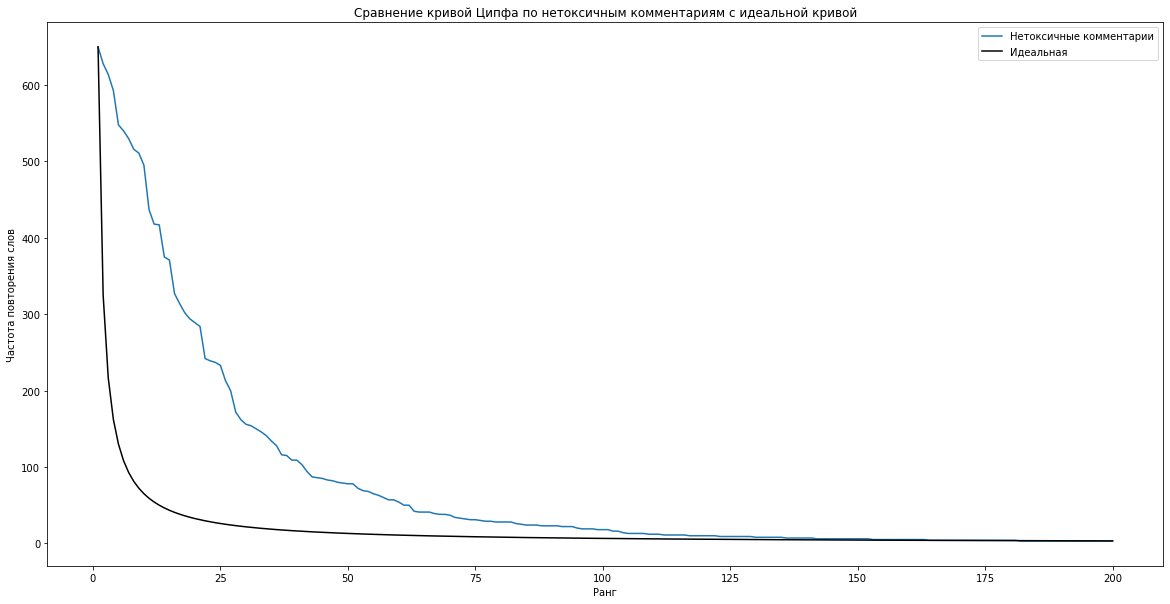

In [19]:
plt.plot(x, non_toxic_freqs[:size], label = "Нетоксичные комментарии")
non_toxic_ideal = [non_toxic_freqs[0] / i for i in x]
plt.plot(x, non_toxic_ideal, color='black', label='Идеальная')

plt.title('Сравнение кривой Ципфа по нетоксичным комментариям с идеальной кривой')
plt.xlabel('Ранг')
plt.ylabel('Частота повторения слов')
plt.legend()
plt.show()

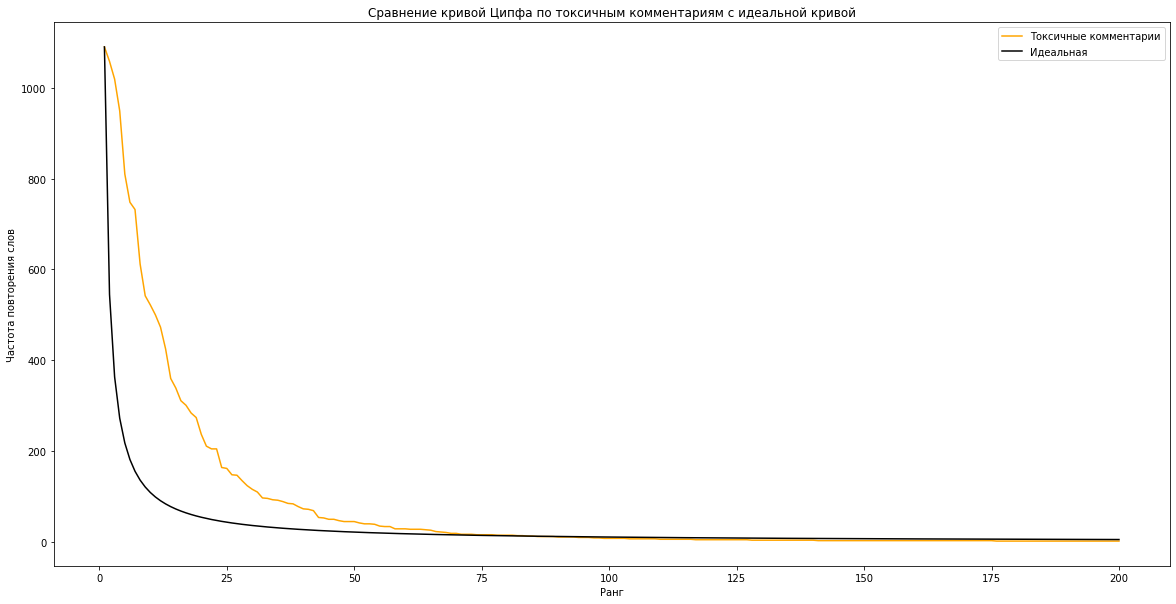

In [20]:
plt.plot(x, toxic_freqs[:size], label = "Токсичные комментарии", color='orange')
toxic_ideal = [toxic_freqs[0] / i for i in x]
plt.plot(x, toxic_ideal, color='black', label='Идеальная')

plt.title('Сравнение кривой Ципфа по токсичным комментариям с идеальной кривой')
plt.xlabel('Ранг')
plt.ylabel('Частота повторения слов')
plt.legend()
plt.show()

### 2.3.5 Кривая Хипса

In [21]:
def get_heaps_values(df, description=None):
    cnt = Counter()
    n_words = []
    n_tokens = []
    tokens = []
    sum_tokens = 0
    for _, row in tqdm(df.iterrows(), total=len(df), desc=description):
        cnt.update(row['tokens'])
        n_words.append(len(cnt))  # записываем накопленное кол-во уникальных слов для текущего твита
        sum_tokens += row['tokens_count']
        n_tokens.append(sum_tokens)  # записываем накопленное кол-во токенов ВСЕГО (включая повторения)
    return n_tokens, n_words, cnt

x_non_toxic, y_non_toxic, non_toxic_cnt = get_heaps_values(non_toxic, 'Подсчет значений для кривой Хипса по нетоксичным комментариям')
x_toxic, y_toxic, toxic_cnt = get_heaps_values(toxic, 'Подсчет значений для кривой Хипса по токсичным комментариям')

Подсчет значений для кривой Хипса по нетоксичным комментариям: 100%|██████████| 16225/16225 [00:01<00:00, 14194.89it/s]
Подсчет значений для кривой Хипса по токсичным комментариям: 100%|████████████| 16225/16225 [00:01<00:00, 14481.42it/s]


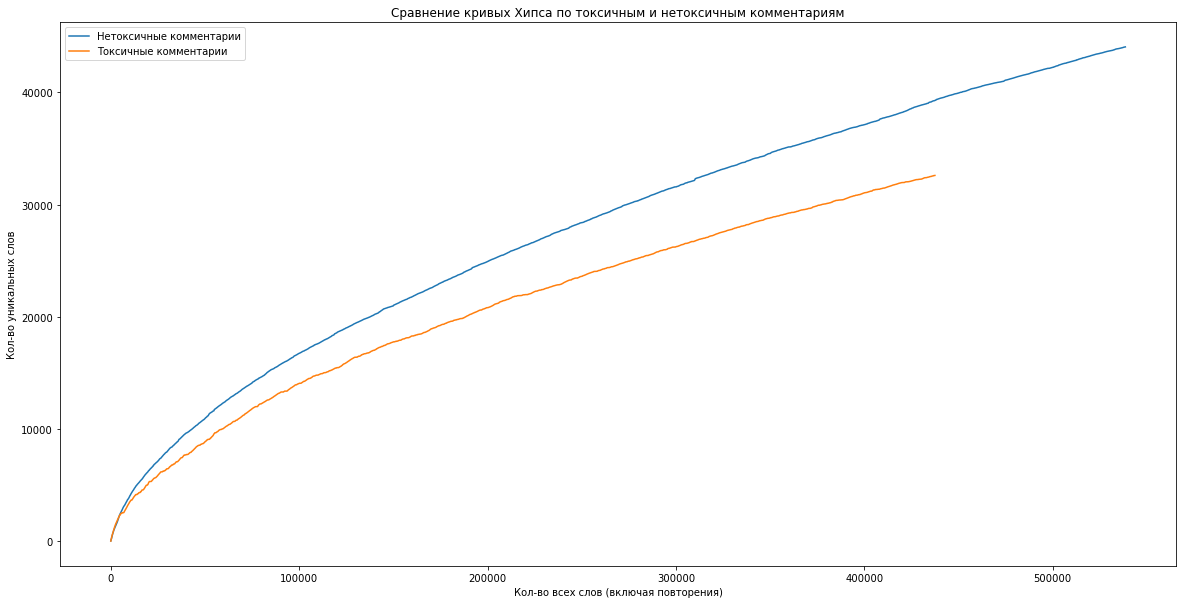

In [22]:
size = min(len(non_toxic), len(toxic))

plt.plot(x_non_toxic[:size], y_non_toxic[:size], label = "Нетоксичные комментарии")
plt.plot(x_toxic[:size], y_toxic[:size], label = "Токсичные комментарии")
plt.legend()
plt.title("Сравнение кривых Хипса по токсичным и нетоксичным комментариям")
plt.xlabel('Кол-во всех слов (включая повторения)')
plt.ylabel('Кол-во уникальных слов')
plt.show()

### 2.3.6. Частотный анализ

In [23]:
print('Самые часто употребляемые слова в токсичных комментариях')
labels = []
sizes = []
explode = []
for word, count in toxic_cnt.most_common(10):
    labels.append(word)
    sizes.append(count)
    explode.append(0.2)

other_words_size = sum(toxic_cnt.values()) - sum(sizes)
labels.append('other')
sizes.append(other_words_size)
explode.append(0)

list(zip(labels, sizes))

Самые часто употребляемые слова в токсичных комментариях


[('fuck', 9623),
 ('shit', 3660),
 ('wikipedia', 3554),
 ('nigger', 3294),
 ('suck', 3245),
 ('fucking', 3238),
 ('go', 2964),
 ('ass', 2955),
 ('u', 2909),
 ('hate', 2637),
 ('other', 399421)]

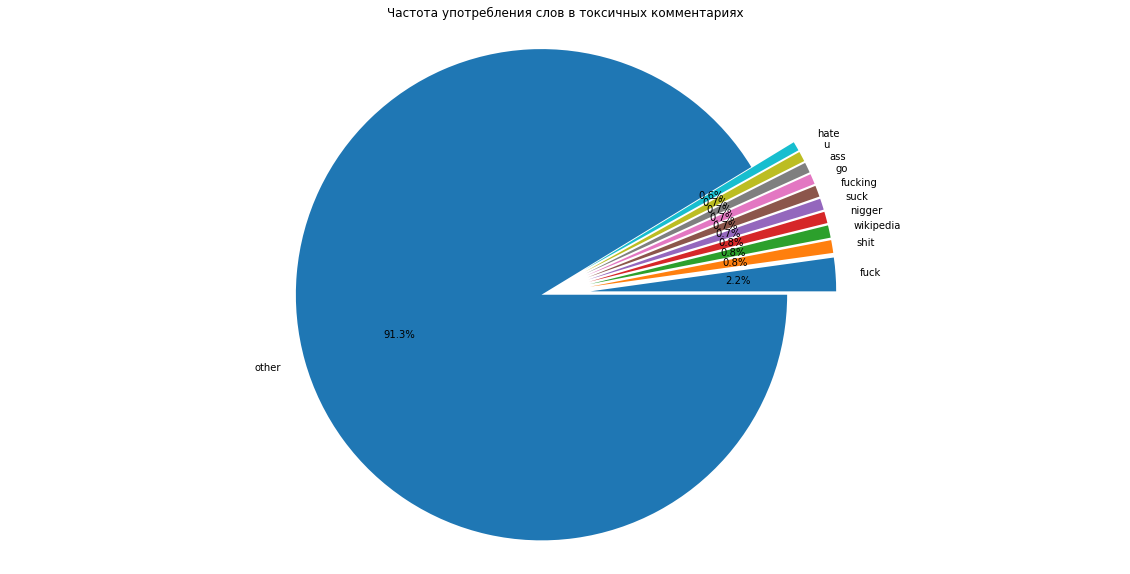

In [24]:
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Частота употребления слов в токсичных комментариях')

plt.show()

In [25]:
print('Самые часто употребляемые слова в нетоксичных комментариях')
labels = []
sizes = []
explode = []
for word, count in non_toxic_cnt.most_common(10):
    labels.append(word)
    sizes.append(count)
    explode.append(0.2)

other_words_size = sum(non_toxic_cnt.values()) - sum(sizes)
labels.append('other')
sizes.append(other_words_size)
explode.append(0)

list(zip(labels, sizes))

Самые часто употребляемые слова в нетоксичных комментариях


[('article', 5993),
 ('page', 5172),
 ('wikipedia', 4621),
 ('talk', 3904),
 ('please', 3137),
 ('one', 3061),
 ('see', 2402),
 ('think', 1998),
 ('edit', 1951),
 ('know', 1889),
 ('other', 504474)]

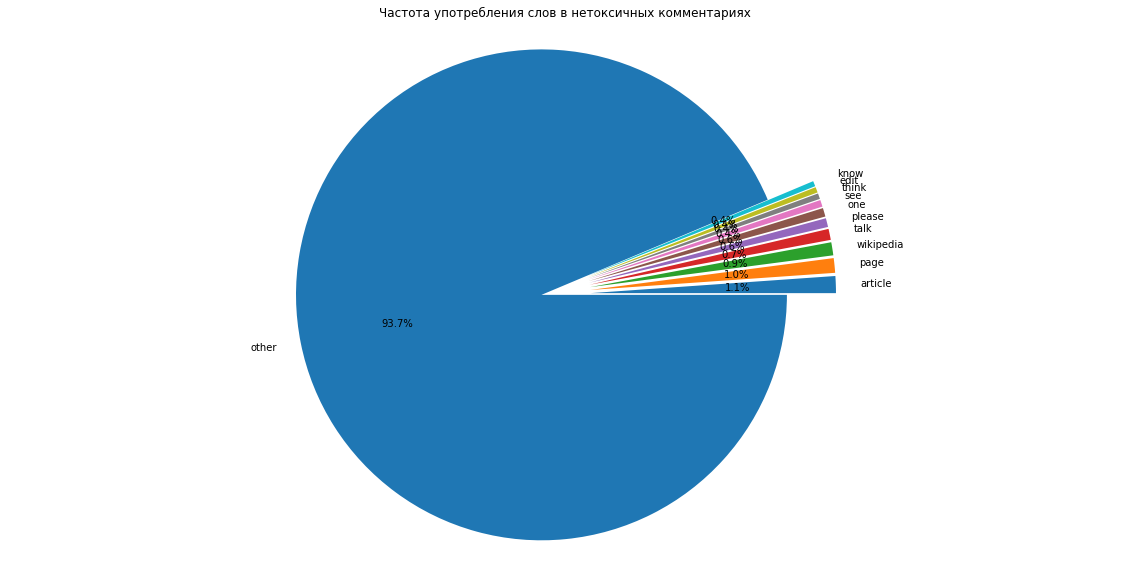

In [26]:
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Частота употребления слов в нетоксичных комментариях')

plt.show()

# 3. Подготовка данных

## 3.2 Feature Engineering - добавляем новые признаки

In [27]:
toxic_set = set(toxic_cnt.keys())
non_toxic_set = set(non_toxic_cnt.keys())

len(toxic_set), len(non_toxic_set)

(32594, 44050)

In [28]:
# Слова, которые есть только в нетоксичных комментариях
non_toxic_only_set = non_toxic_set - toxic_set
list(non_toxic_only_set)[:10]

['havre',
 'hopsonroad',
 'santas',
 'infrared',
 'lira',
 'lgns',
 'pupil',
 'homestar',
 'plottings',
 'apartments']

In [29]:
# Слова, которые есть только в токсичных комментариях
toxic_only_set = toxic_set - non_toxic_set
list(toxic_only_set)[:10]

['yrold',
 'zoloft',
 'blackness',
 'potiental',
 'monarchistic',
 'ting',
 'updatin',
 'citizendium',
 'uncollaborative',
 'pwok']

In [30]:
# rank - величина, показывающая кол-во слов в комментарии,
# характерных только для токсичных (если rank отрицательный)
# либо нетоксичных (если rank положительный) комментариев
toxic['rank'] = toxic['tokens'].apply(lambda tokens: -len(set(tokens) & toxic_only_set))
toxic.head()

,text,toxic,tokens,tokens_count,char_count,rank
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,"[cocksucker, piss, around, work]",4,44,-1
12,Hey... what is it..\n@ | talk .\nWhat is it......,1,"[hey, talk, exclusive, group, wp, talibans, go...",25,319,-3
16,"Bye! \n\nDon't look, come or think of comming ...",1,"[bye, look, come, think, comming, back, tosser]",7,57,0
42,You are gay or antisemmitian? \n\nArchangel WH...,1,"[gay, antisemmitian, archangel, white, tiger, ...",58,648,-9
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,"[fuck, filthy, mother, ass, dry]",5,40,0


In [31]:
non_toxic['rank'] = non_toxic['tokens'].apply(lambda tokens: len(set(tokens) & non_toxic_only_set))
non_toxic.head()

,text,toxic,tokens,tokens_count,char_count,rank
0,Explanation\nWhy the edits made under my usern...,0,"[explanation, edits, made, username, hardcore,...",22,264,2
1,D'aww! He matches this background colour I'm s...,0,"[matches, background, colour, seemingly, stuck...",9,112,0
2,"Hey man, I'm really not trying to edit war. It...",0,"[hey, man, really, trying, edit, war, guy, con...",21,233,0
3,"""\nMore\nI can't make any real suggestions on ...",0,"[make, real, suggestions, improvement, wondere...",46,622,2
4,"You, sir, are my hero. Any chance you remember...",0,"[sir, hero, chance, remember, page]",5,67,0


## 3.3 Сборка финальных датасетов для моделирования

In [32]:
data = pd.concat([toxic, non_toxic])[['tokens', 'tokens_count', 'char_count', 'rank', 'toxic']].sort_index()
data['tokens'] = data['tokens'].str.join(' ')
data.head()

,tokens,tokens_count,char_count,rank,toxic
0,explanation edits made username hardcore metal...,22,264,2,0
1,matches background colour seemingly stuck than...,9,112,0,0
2,hey man really trying edit war guy constantly ...,21,233,0,0
3,make real suggestions improvement wondered sec...,46,622,2,0
4,sir hero chance remember page,5,67,0,0


In [33]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data['tokens'])
vectors

<32450x59178 sparse matrix of type '<class 'numpy.float64'>'
	with 716508 stored elements in Compressed Sparse Row format>

In [34]:
columns = np.array(data[['tokens_count', 'char_count', 'rank']])
columns[:5]

array([[ 22, 264,   2],
       [  9, 112,   0],
       [ 21, 233,   0],
       [ 46, 622,   2],
       [  5,  67,   0]], dtype=int64)

In [35]:
X = hstack([vectors, columns])
X

<32450x59181 sparse matrix of type '<class 'numpy.float64'>'
	with 801623 stored elements in COOrdinate format>

In [36]:
y = data['toxic']
y[:5]

0    0
1    0
2    0
3    0
4    0
Name: toxic, dtype: int64

# 4. Моделирование

In [37]:
clf = RandomForestClassifier(verbose=2, n_jobs=-1)
scores = cross_val_score(clf, X, y, cv=3, scoring='f1_macro', verbose=True)
print(sum(scores) / len(scores), scores)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Pa

0.9321106759435831 [0.93127799 0.9313637  0.93369034]


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   57.9s finished


In [38]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
scores = cross_val_score(clf, X, y, cv=3, scoring='f1_macro', verbose=True)
print(sum(scores) / len(scores), scores)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.9370936583218962 [0.94558577 0.9354717  0.93022351]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.2s finished


In [39]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(verbose=2)
scores = cross_val_score(clf, X, y, cv=3, scoring='f1_macro', verbose=True, n_jobs=-1)
print(sum(scores) / len(scores), scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


0.9240447682600385 [0.92403326 0.92189237 0.92620868]


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.7min finished


# 5. Оценка

## 5.1 Модель

In [40]:
filename = 'model.pkl'

if os.path.exists(filename):
    # загрузка существующей модели из файла
    print('Загрузка модели...')
    model = pickle.load(open(filename, 'rb'))
else:
    print('Обучение модели...')
    model = RandomForestClassifier(verbose=2, n_jobs=-1)
    model.fit(X, y)
    # сохранение обученной модели в файл
    print('Сохранение модели в файл...')
    pickle.dump(model, open(filename, 'wb'))
print('Готово')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Обучение модели...
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100building tree 4 of 100

building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.7s


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.4s finished


In [41]:
X_test = hstack([
    vectorizer.transform(['Hey man whats up?', 'Dickhead cocksucker']),
    np.array([[0, 0, 0], [0, 0, 0]])
])
model.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


array([1, 1], dtype=int64)